## Baseline receiver stateless monitoring 

In [1]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages "
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.6,"
    "org.apache.spark:spark-streaming-kafka-0-10_2.12:3.5.6 "
    "pyspark-shell"
)

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("read_test_straeam") \
        .getOrCreate()

:: loading settings :: url = jar:file:/home/guest/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/guest/.ivy2/cache
The jars for the packages stored in: /home/guest/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-be37b203-5ad5-4726-856f-f56f7a2aa86d;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.6 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.6 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in c

In [3]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType

KAFKA_BOOTSTRAP_SERVERS = "127.0.0.1:9092"
KAFKA_TOPIC = "sensors"


schema = StructType().add("sensor", StringType())\
                     .add("info", StructType()\
                          .add("timestamp_sent", StringType())\
                          .add("timestamp_received", StringType())\
                          .add("obs", StringType())\
                          .add("drift", StringType()))

df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP_SERVERS) \
  .option("subscribe", KAFKA_TOPIC) \
  .option("startingOffsets", "earliest") \
  .load()\
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))\
            .select(col("parsed_value.sensor"), \
                    col("parsed_value.info.timestamp_sent"),\
                    col("parsed_value.info.timestamp_received"),\
                    col("parsed_value.info.obs"),\
                    col("parsed_value.info.drift"))

In [4]:
df.printSchema()

root
 |-- sensor: string (nullable = true)
 |-- timestamp_sent: string (nullable = true)
 |-- timestamp_received: string (nullable = true)
 |-- obs: string (nullable = true)
 |-- drift: string (nullable = true)



In [5]:
final_df = spark.read.csv("/home/guest/notebooks/data/output/day=*/hour=*", header=True, inferSchema=True)
final_df.take(5)

[Row(sensor='sensor-2', count_obs=1382, avg_obs=7.299, +/-std_obs=7.851, max_obs=9.309, min_obs=-0.006, sum_miss_obs=118, avg_time_delay=7200.0, window_start=datetime.datetime(2025, 6, 25, 10, 34), window_end=datetime.datetime(2025, 6, 25, 10, 35)),
 Row(sensor='sensor-1', count_obs=200, avg_obs=17.831, +/-std_obs=13.197, max_obs=8.198, min_obs=-0.071, sum_miss_obs=0, avg_time_delay=7200.0, window_start=datetime.datetime(2025, 6, 25, 10, 41), window_end=datetime.datetime(2025, 6, 25, 10, 42)),
 Row(sensor='sensor-2', count_obs=560, avg_obs=5.597, +/-std_obs=6.685, max_obs=9.309, min_obs=-0.006, sum_miss_obs=40, avg_time_delay=7200.0, window_start=datetime.datetime(2025, 6, 25, 10, 18), window_end=datetime.datetime(2025, 6, 25, 10, 19)),
 Row(sensor='sensor-2', count_obs=1394, avg_obs=4.944, +/-std_obs=6.016, max_obs=9.874, min_obs=-0.004, sum_miss_obs=106, avg_time_delay=7200.0, window_start=datetime.datetime(2025, 6, 25, 10, 42), window_end=datetime.datetime(2025, 6, 25, 10, 43)),
 Ro

In [6]:
final_df.orderBy(col("window_start").asc()).coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("/home/guest/notebooks/final_output/")

In [9]:
import pandas as pd

pandas_df = pd.read_csv("/home/guest/notebooks/final_output/part-00000-634bfa80-6d99-4e87-85f7-903b93fff5e4-c000.csv")
pandas_df.tail()

,sensor,count_obs,avg_obs,+/-std_obs,max_obs,min_obs,sum_miss_obs,avg_time_delay,window_start,window_end
208,sensor-3,12,0.279,2.657,4.448,-0.179,0,7200.0,2025-06-26T11:24:00.000Z,2025-06-26T11:25:00.000Z
209,sensor-1,12,3.496,3.234,9.248,-2.081,0,7200.0,2025-06-26T11:24:00.000Z,2025-06-26T11:25:00.000Z
210,sensor-1,12,1.114,2.449,4.966,-0.191,0,7200.0,2025-06-26T11:25:00.000Z,2025-06-26T11:26:00.000Z
211,sensor-3,12,0.981,2.141,5.073,-0.035,0,7200.0,2025-06-26T11:25:00.000Z,2025-06-26T11:26:00.000Z
212,sensor-2,12,3.900,3.310,8.493,-3.731,0,7200.0,2025-06-26T11:25:00.000Z,2025-06-26T11:26:00.000Z


In [10]:
pandas_df["datetime"] = pd.to_datetime(pandas_df["window_end"])

In [11]:
sorted_df = pandas_df[(pandas_df["datetime"]>="2025-06-26 10:50:00+00:00")].sort_values(by='datetime').set_index("datetime")

In [12]:
sorted_df.groupby("sensor").avg_obs.sum()

sensor
sensor-1    325.647
sensor-2    105.258
sensor-3    167.531
Name: avg_obs, dtype: float64

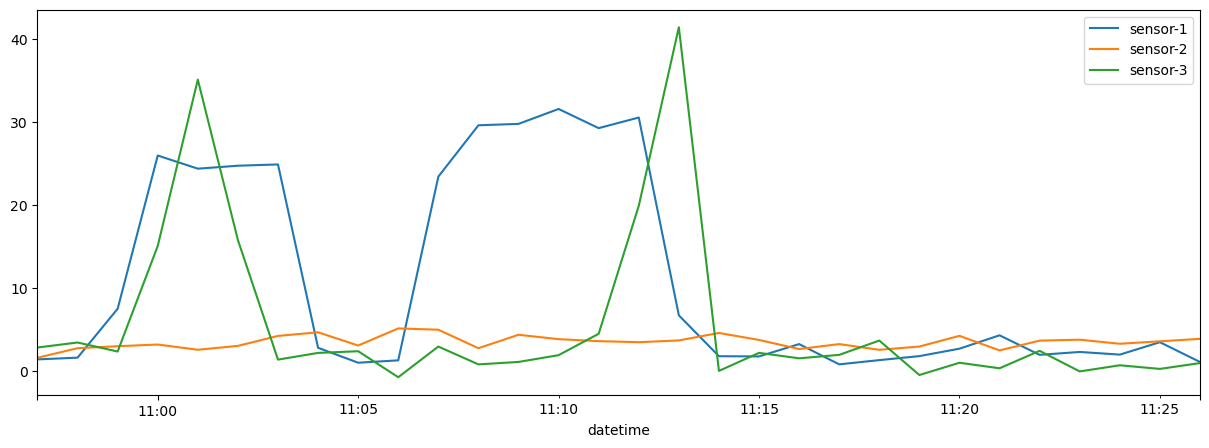

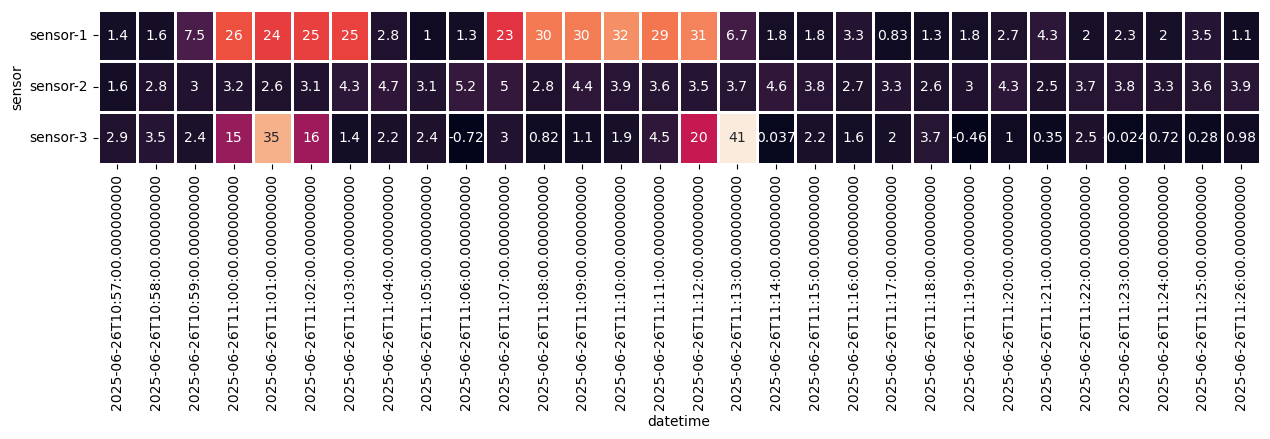

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

df_avg = sorted_df[["sensor", "avg_obs"]].pivot(columns='sensor', values='avg_obs')

sorted_df.groupby("sensor").avg_obs.plot(figsize=(15,5))
plt.legend()
plt.plot()

plt.figure(figsize=(15, 2))
sns.heatmap(df_avg.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()

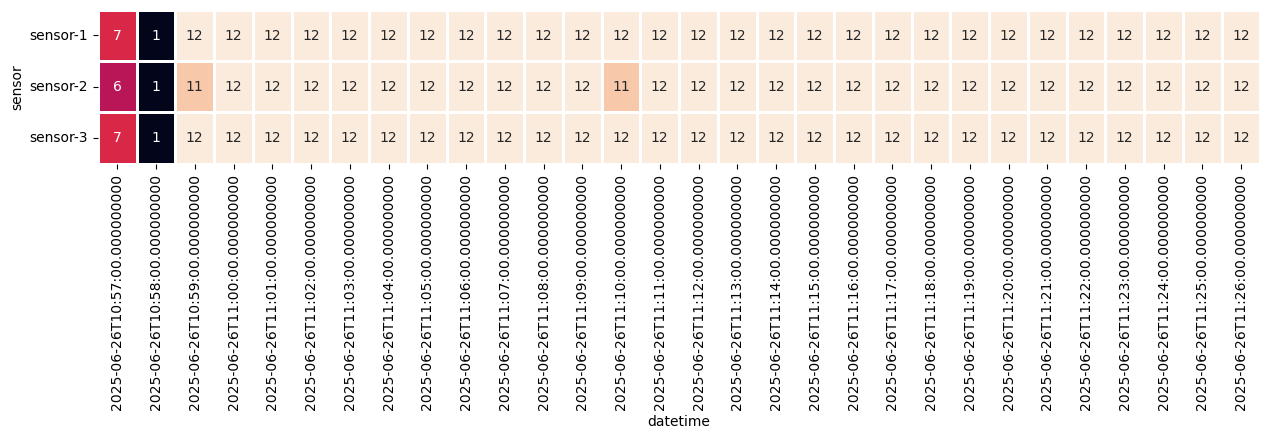

In [15]:


df_counts = sorted_df[["sensor", "count_obs"]].pivot(columns='sensor', values='count_obs')

plt.figure(figsize=(15, 2))
sns.heatmap(df_counts.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()

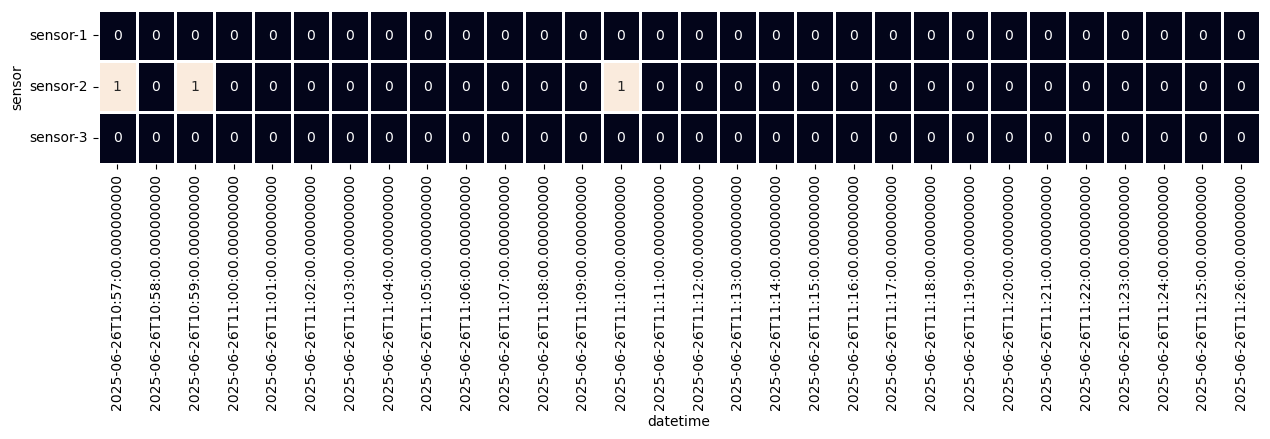

In [18]:
df_misses = sorted_df[["sensor", "sum_miss_obs"]].pivot(columns='sensor', values='sum_miss_obs')

plt.figure(figsize=(15, 2))
sns.heatmap(df_misses.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.show()
